## Learning a function from a formula

### Learning a simple real function

We're going to teach to a physics-informed neural network the gaussian function:

$$
    f(x) = e^{- x^2}
$$

In [1]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import deepxde as xde

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
def history(losshistory):

    # Plotting history progress
    steps = np.array(losshistory.steps).ravel()
    loss_test = np.array(losshistory.loss_test).ravel()
    loss_train = np.array(losshistory.loss_train).ravel()
    metrics_test = np.array([x[0] if len(x) > 0 else np.nan for x in losshistory.metrics_test])

    plt.plot(steps, loss_test, color = 'blue', linestyle = 'dotted', label = 'Loss test')
    plt.plot(steps, loss_train, color = 'red', linestyle = 'dashed', label = 'Loss train')
    plt.plot(steps, metrics_test, color = 'black', label = 'L2 metrics test')
    plt.title('Loss history')
    plt.xlabel('Steps')
    plt.ylabel('Loss value')
    plt.legend()
    plt.show()

    return None

def plot(x, y_true, model):

    # Making predictions
    y_pred = model.predict(x.reshape(len(x), 1)).ravel()

    _, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (8, 8))

# Top subplot: True function and prediction
    ax1.plot(x, y_true, label = 'True Function', color = 'black')
    ax1.plot(x, y_pred, label = 'Predicted values', color = 'red', linestyle = '--')
    ax1.set_title('Learnt Function')
    ax1.set_ylabel('y')
    ax1.legend()
    ax1.grid()

# Middle subplot: Residuals
    residuals = y_true - y_pred
    ax2.plot(x, residuals, color = 'blue', label = 'Residuals')
    ax2.axhline(y = 0, color = 'black', linestyle = '--', linewidth = 1)
    ax2.set_title('Residual Plot')
    ax2.set_xlabel('x')
    ax2.set_ylabel('Residual (y_true - y_pred)')
    ax2.legend()
    ax2.grid()

# Bottom subplot: Histogram of residuals
    ax3.hist(residuals, bins = 50, color = 'green', alpha = 0.7, edgecolor = 'black')
    ax3.axvline(x = 0, color = 'black', linestyle = '--', linewidth = 2)
    ax3.set_title('Residual Distribution')
    ax3.set_xlabel('Residual Value')
    ax3.set_ylabel('Frequency')
    ax3.grid()

    plt.tight_layout()
    plt.show()

# Calculating and print some error metrics
    mse = np.mean(residuals ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(residuals))
    max_error = np.max(np.abs(residuals))

    print(f"Mean Squared Error: {mse:.1e}")
    print(f"Root Mean Squared Error: {rmse:.1e}")
    print(f"Mean Absolute Error: {mae:.1e}")
    print(f"Maximum Absolute Error: {max_error:.1e}")

    return None

In [3]:
# Defining the gaussian function
gaussian = lambda x: np.exp(- x ** 2)

In [4]:
# Defining the interval
interval = xde.geometry.Interval(- 3, 3)

In [5]:
# Defining the dataset
dataset = xde.data.Function(geometry = interval, 
                            function = gaussian,
                            num_train = 500,
                            num_test = 500,
                            train_distribution = 'uniform',
                            online = False)

In [6]:
# Defining the network
network = xde.nn.FNN(layer_sizes = [1] + [10] * 3 + [1],
                     activation = "tanh",
                     kernel_initializer = "Glorot normal")

In [7]:
# Defining the model
model = xde.Model(dataset, network)

In [8]:
# Early stop
halt = xde.callbacks.EarlyStopping(min_delta = 1e-05,
                                   patience = 2_000,
                                   baseline = None,
                                   monitor = 'loss_train',
                                   start_from_epoch = 0)

# Training the model
model.compile(optimizer = "adam",
              lr = 1e-03,
              metrics = ["l2 relative error"],
              loss = 'MSE')

losshistory, _ = model.train(iterations = 10_000,
                             callbacks = [halt])

Compiling model...
'compile' took 2.861226 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [2.13e-01]    [2.13e-01]    [1.01e+00]    
1000      [2.25e-04]    [2.25e-04]    [3.28e-02]    
2000      [8.08e-05]    [8.08e-05]    [1.97e-02]    
3000      [2.53e-05]    [2.53e-05]    [1.10e-02]    
4000      [9.95e-06]    [9.95e-06]    [6.91e-03]    
5000      [3.25e-06]    [3.25e-06]    [3.95e-03]    
6000      [1.78e-06]    [1.78e-06]    [2.92e-03]    
Epoch 6000: early stopping

Best model at step 6000:
  train loss: 1.78e-06
  test loss: 1.78e-06
  test metric: [2.92e-03]

'train' took 27.288065 s



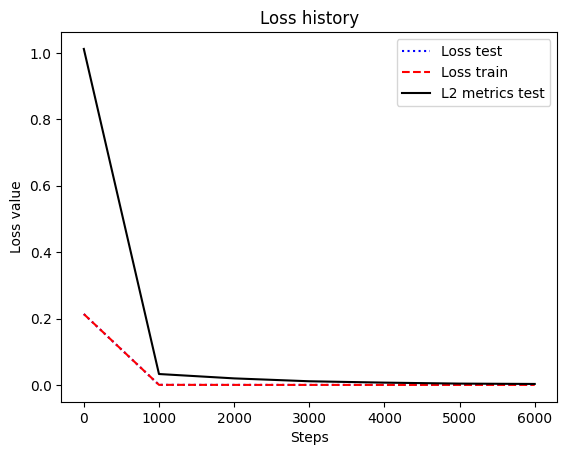

In [9]:
# Plotting history
history(losshistory)

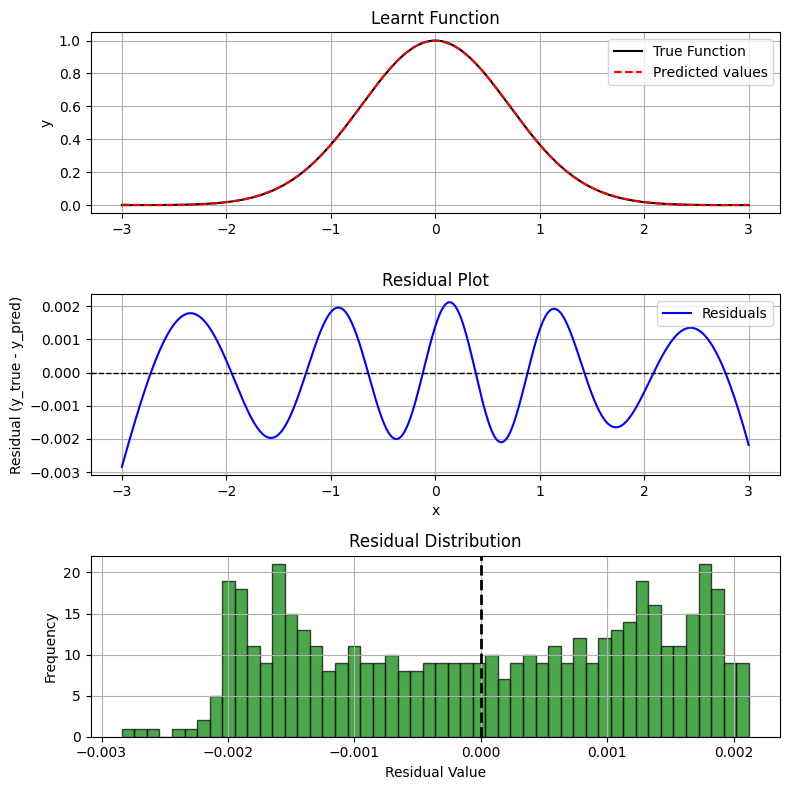

Mean Squared Error: 1.8e-06
Root Mean Squared Error: 1.3e-03
Mean Absolute Error: 1.2e-03
Maximum Absolute Error: 2.8e-03


In [10]:
# Making predictions
x = np.linspace(-3, 3, 500, dtype = np.float32)
y_true = gaussian(x)

plot(x, y_true, model)

### Learning a function depending on 2 variables

Let's create a neural network to learn a periodic function within a disk:

$$
    f(x, y) = \cos(x) \sin(y)
$$

In [11]:
# Defining the function
cosx_siny = lambda xy: np.cos(xy[:, 0:1]) * np.sin(xy[:, 1:2])

# Defining the disk
disk = xde.geometry.Disk(center = (0, 0),
                         radius = np.pi)

# Defining the dataset
dataset = xde.data.Function(geometry = disk, 
                            function = cosx_siny,
                            num_train = 1000,
                            num_test = 1000,
                            train_distribution = 'pseudo',
                            online = False)

# Defining the network
network = xde.nn.FNN(layer_sizes = [2] + [10] * 3 + [1],
                     activation = "tanh",
                     kernel_initializer = "Glorot normal")

# Defining the model
model = xde.Model(dataset, network)

# Early stop
halt = xde.callbacks.EarlyStopping(min_delta = 1e-05,
                                   patience = 2_000,
                                   baseline = None,
                                   monitor = 'loss_train',
                                   start_from_epoch = 0)

# Training the model
model.compile(optimizer = "adam", # Adam optimizer
              lr = 1e-03,
              metrics = ["l2 relative error"],
              loss = 'MSE')

losshistory, train_state = model.train(iterations = 15_000,
                                       callbacks = [halt])

Compiling model...
'compile' took 0.000538 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [2.90e-01]    [2.89e-01]    [1.10e+00]    
1000      [6.33e-04]    [6.83e-04]    [5.35e-02]    
2000      [3.92e-04]    [4.18e-04]    [4.19e-02]    
3000      [2.38e-04]    [2.46e-04]    [3.21e-02]    
4000      [1.60e-04]    [1.62e-04]    [2.61e-02]    
5000      [1.18e-04]    [1.23e-04]    [2.27e-02]    
6000      [9.34e-05]    [9.80e-05]    [2.03e-02]    
7000      [8.12e-05]    [8.72e-05]    [1.91e-02]    
8000      [6.90e-05]    [7.20e-05]    [1.74e-02]    
9000      [6.15e-05]    [6.45e-05]    [1.65e-02]    
10000     [5.33e-05]    [5.71e-05]    [1.55e-02]    
11000     [4.69e-05]    [5.01e-05]    [1.45e-02]    
12000     [7.06e-05]    [8.06e-05]    [1.84e-02]    
Epoch 12000: early stopping

Best model at step 11000:
  train loss: 4.69e-05
  test loss: 5.01e-05
  test metric: [1.45e-02]

'train' took 62.642907 s



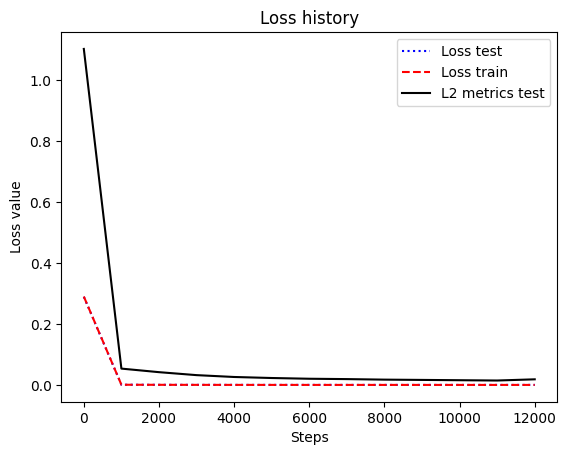

In [12]:
# Plotting history
history(losshistory)

Mean Squared Error: 8.1e-05
Root Mean Squared Error: 9.0e-03
Mean Absolute Error: 6.9e-03
Maximum Absolute Error: 5.0e-02


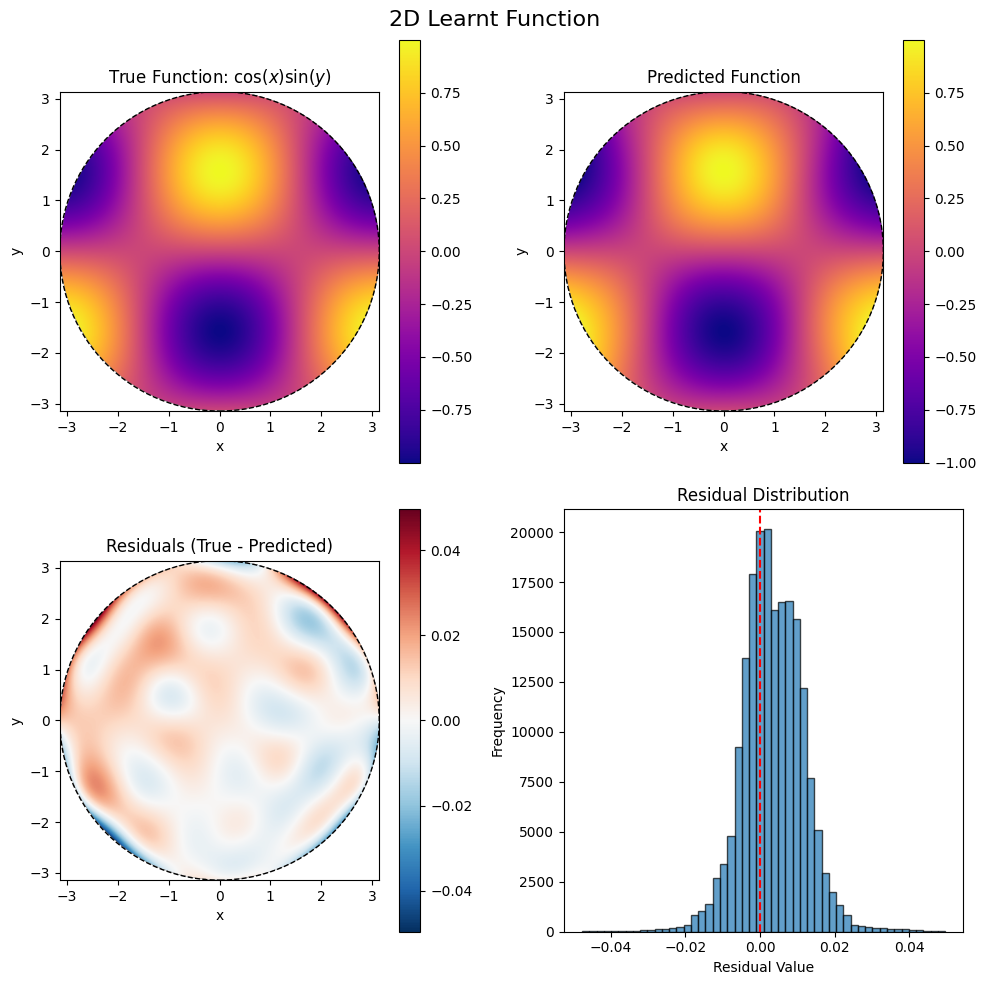

In [13]:
from matplotlib.patches import Circle

# Creating a grid of points within the disk
n_points = 500
x = np.linspace(- np.pi, np.pi, n_points)
y = np.linspace(- np.pi, np.pi, n_points)
X, Y = np.meshgrid(x, y)

# Creating a mask for points inside the disk
mask = (X ** 2 + Y ** 2) <= np.pi ** 2

# Flatten the grid and filter points inside the disk
points = np.vstack([X.ravel(), Y.ravel()]).T
points = points[mask.ravel()]

# Getting true values and predictions
true_values = np.cos(points[:, 0]) * np.sin(points[:, 1])
predicted_values = model.predict(points).ravel()

# Creating arrays for plotting (with NaN outside the disk)
true_grid = np.full(X.shape, np.nan)
predicted_grid = np.full(X.shape, np.nan)
residual_grid = np.full(X.shape, np.nan)

true_grid[mask] = true_values
predicted_grid[mask] = predicted_values
residual_grid[mask] = true_values - predicted_values

# Creating figure with subplots
fig, axes = plt.subplots(2, 2, figsize = (10, 10))
fig.suptitle('2D Learnt Function', fontsize = 16)

# Plotting true function
im1 = axes[0, 0].imshow(true_grid, extent = [- np.pi, np.pi, - np.pi, np.pi], origin = 'lower', cmap = 'plasma')

axes[0, 0].set_title('True Function: $\\cos(x) \\sin(y)$')
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('y')
fig.colorbar(im1, ax = axes[0, 0])

# Adding circle to show disk boundary
circle = Circle((0, 0), np.pi, fill = False, color = 'black', linestyle = '--')
axes[0, 0].add_patch(circle)

# Plotting predicted function
im2 = axes[0, 1].imshow(predicted_grid, extent = [- np.pi, np.pi, - np.pi, np.pi], origin = 'lower', cmap = 'plasma')

axes[0, 1].set_title('Predicted Function')
axes[0, 1].set_xlabel('x')
axes[0, 1].set_ylabel('y')
fig.colorbar(im2, ax = axes[0, 1])
circle = Circle((0, 0), np.pi, fill = False, color = 'black', linestyle = '--')
axes[0, 1].add_patch(circle)

# Plotting residuals
vmax = max(np.abs(np.nanmin(residual_grid)), np.abs(np.nanmax(residual_grid)))
im3 = axes[1, 0].imshow(residual_grid, extent=[- np.pi, np.pi, - np.pi, np.pi], origin = 'lower', cmap = 'RdBu_r', vmin = -vmax, vmax = vmax)

axes[1, 0].set_title('Residuals (True - Predicted)')
axes[1, 0].set_xlabel('x')
axes[1, 0].set_ylabel('y')
fig.colorbar(im3, ax = axes[1, 0])
circle = Circle((0, 0), np.pi, fill = False, color = 'black', linestyle = '--')
axes[1, 0].add_patch(circle)

# Plotting error distribution
residuals = true_values - predicted_values
axes[1, 1].hist(residuals, bins = 50, alpha = 0.7, edgecolor = 'black')
axes[1, 1].axvline(x = 0, color = 'r', linestyle = '--')
axes[1, 1].set_title('Residual Distribution')
axes[1, 1].set_xlabel('Residual Value')
axes[1, 1].set_ylabel('Frequency')

# Calculating and print some error metrics
mse = np.mean(residuals ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(residuals))
max_error = np.max(np.abs(residuals))

print(f"Mean Squared Error: {mse:.1e}")
print(f"Root Mean Squared Error: {rmse:.1e}")
print(f"Mean Absolute Error: {mae:.1e}")
print(f"Maximum Absolute Error: {max_error:.1e}")

plt.tight_layout()
plt.show()

## Learning a function from a dataset

We're going to create and give to a neural network a synthetic dataset $(t, y)$

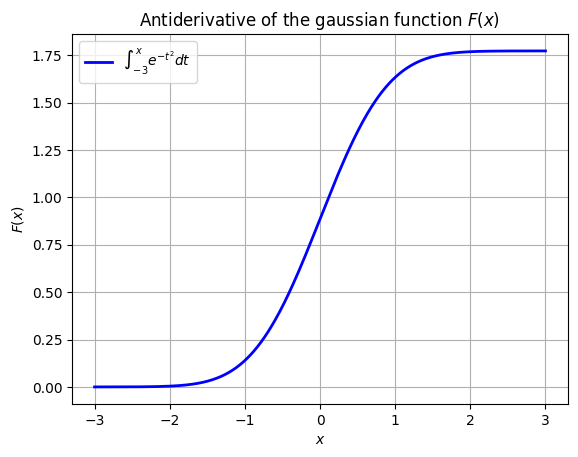

In [14]:
# Importing cumulative trapezoid from SciPy
from scipy.integrate import cumulative_trapezoid

# Computing the cumulative integral of the gaussian function
t = np.linspace(- 3, 3, 500)
y = gaussian(t)

integral = cumulative_trapezoid(y, t, initial = 0)

plt.plot(t, integral, color = 'blue', label = r"$\int_{-3}^{x} e^{-t^2} dt$", linewidth = 2)
plt.title('Antiderivative of the gaussian function $F(x)$')
plt.xlabel('$x$')
plt.ylabel('$F(x)$')
plt.legend()
plt.grid()
plt.show()

In [15]:
# Splitting the dataset in train and test
from sklearn.model_selection import train_test_split

t_train, t_test, integral_train, integral_test = train_test_split(t,
                                                                  integral,
                                                                  test_size = 0.2,
                                                                  train_size = 0.8,
                                                                  random_state = 47,
                                                                  shuffle = True)

In [16]:
# Reshaping data for the model
def reshape(array):
    return array.reshape(len(array), 1)

t_train_for_model = reshape(t_train)
integral_train_for_model = reshape(integral_train)
t_test_for_model = reshape(t_test)
integral_test_for_model = reshape(integral_test)

In [17]:
# Defining the dataset for the network
dataset = xde.data.DataSet(X_train = t_train_for_model,
                           y_train = integral_train_for_model,
                           X_test = t_test_for_model,
                           y_test = integral_test_for_model,
                           standardize = False)

In [18]:
# Defining the network
network = xde.nn.FNN(layer_sizes = [1] + [10] * 3 + [1],
                     activation = "tanh",
                     kernel_initializer = "Glorot normal")

# Defining the model
model = xde.Model(dataset, network)

# Early stop
halt = xde.callbacks.EarlyStopping(min_delta = 1e-05,
                                   patience = 2_000,
                                   baseline = None,
                                   monitor = 'loss_train',
                                   start_from_epoch = 0)

# Training the model
model.compile(optimizer = "adam", # Adam optimizer
              lr = 1e-03,
              metrics = ["l2 relative error"],
              loss = 'MSE')

losshistory, _ = model.train(iterations = 10_000,
                             callbacks = [halt])

Compiling model...
'compile' took 0.000716 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.64e+00]    [1.90e+00]    [1.12e+00]    
1000      [1.17e-04]    [1.60e-04]    [1.03e-02]    
2000      [4.86e-05]    [6.01e-05]    [6.28e-03]    
3000      [3.09e-05]    [3.24e-05]    [4.61e-03]    
4000      [2.62e-05]    [2.60e-05]    [4.14e-03]    
5000      [2.14e-05]    [2.11e-05]    [3.72e-03]    
Epoch 5000: early stopping

Best model at step 5000:
  train loss: 2.14e-05
  test loss: 2.11e-05
  test metric: [3.72e-03]

'train' took 24.337638 s



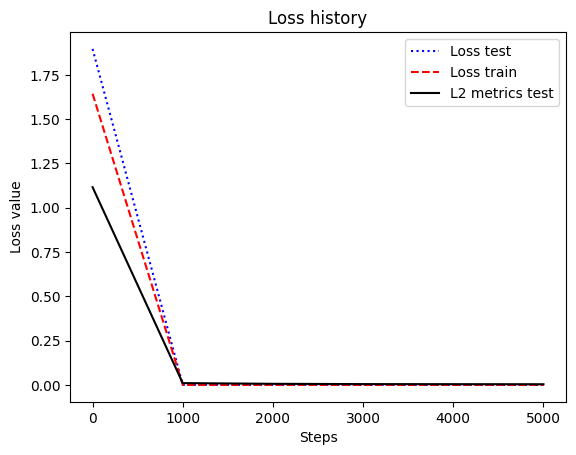

In [19]:
history(losshistory)

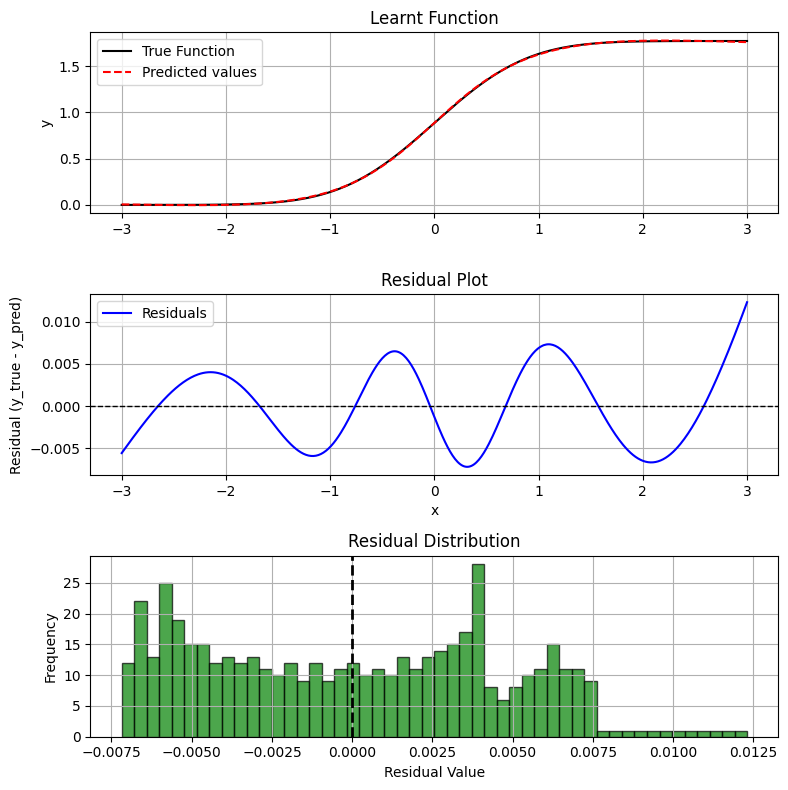

Mean Squared Error: 2.1e-05
Root Mean Squared Error: 4.6e-03
Mean Absolute Error: 4.0e-03
Maximum Absolute Error: 1.2e-02


In [20]:
plot(t, integral, model)

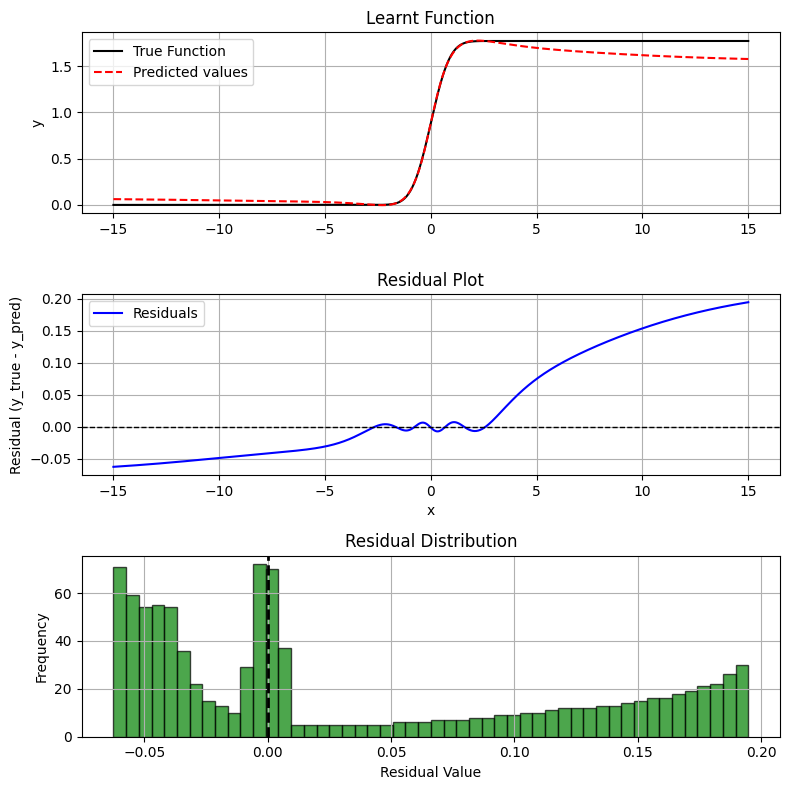

Mean Squared Error: 8.7e-03
Root Mean Squared Error: 9.3e-02
Mean Absolute Error: 7.1e-02
Maximum Absolute Error: 1.9e-01


In [21]:
# Beyond its limits
t = np.linspace(- 15, 15, 1000)
y = gaussian(t)
integral = cumulative_trapezoid(y, t, initial = 0)

plot(t, integral, model)